In [1]:
import re
import numpy as np
import pandas as pd
import os
from os import walk
import math

import cv2 as cv
import networkx as nx

import chart_studio.plotly as py
import plotly.offline as py
import plotly.graph_objects as go
import matplotlib.pyplot as plt
#from Shapes import shapes
#from Lines import lines


In [2]:
from ipywidgets import interact

### Pulling in Data

In [54]:
file_path = '/Users/agetecza/CAM_Data/AT_CAM/Data/Clean' #path to data on local computer

In [4]:
#Function to get unique elements from a list
def list_unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
            
    return unique_list

In [55]:
def make_id_list(my_file_path):

    #pull all filenames in your data directory
    _, _, filenames = next(walk(my_file_path))

    #grab only the id from the filenames to feed to the function
    id_list = []
    for filename in filenames:
        filename_split = filename.rsplit('_', 1)
        id_list.append(filename_split[0])
    
    unique_id = list_unique(id_list) #drop duplicate ids, since they are the same for _blocks & _links
        
    
    
    return unique_id

In [56]:
#Get an id_list from your specific file path
my_id_list = make_id_list(file_path)

In [57]:
#Look at total number of cams
len(my_id_list)

159

### Looking at a single CAM

In [8]:
cam_id = my_id_list[3] #grab a single id to just look through code

blocks = pd.read_csv(f'{file_path}/{cam_id}_blocks.csv')
links = pd.read_csv(f'{file_path}/{cam_id}_links.csv')

display(blocks.head())
display(links.head())

,id,title,x_pos,y_pos,width,height,shape,creator,num,comment,timestamp,modifiable,CAM
0,14686,Unequal effect on classes and regions,56.0,160.0,160.0,120.0,negative,845,5.0,Temperature regulation of homes is a main powe...,20:01:57,1,990
1,14694,Practical way to address problem,697.0,268.0,160.0,120.0,positive weak,845,7.0,"This is one of the ""solutions"" that is more re...",20:05:28,1,990
2,14672,Increased tax,187.0,54.0,160.0,120.0,negative strong,845,3.0,NaN,19:50:42,1,990
3,14673,Meant to fight climate change,646.0,128.0,160.0,120.0,positive,845,4.0,NaN,19:50:22,1,990
4,14667,Carbon Tax,390.0,201.0,160.0,120.0,neutral,845,1.0,NaN,NaN,1,990


,id,starting_block,ending_block,line_style,creator,num,arrow_type,timestamp,CAM
0,9328,14667,14673,Solid-Weak,845,0,none,19:38:14,990
1,9329,14669,14673,Solid-Weak,845,0,none,19:38:18,990
2,9330,14667,14672,Solid-Weak,845,0,none,19:38:25,990
3,9341,14672,14686,Solid-Weak,845,0,none,19:42:22,990
4,9342,14673,14694,Solid-Weak,845,0,none,19:44:33,990


## Create A Graph Using Networkx

### Create a function to build most basic graph

In [9]:
def graph_from_df(node_df, edge_df):
    # Get nodes
    nodes = node_df['id'].to_list()
    
    # Get edges
    edge_start = edge_df['starting_block'].to_list()
    edge_end = edge_df['ending_block'].to_list()
    edges = tuple(zip(edge_start, edge_end))
    
    # Create Graph
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

In [10]:
G = graph_from_df(blocks,links)

### Create a function to add attributes 

In [11]:
def add_node_attributes(graph_name, node_df, attr_name): #attr_column_name must be in quotes
    
    blocks_dict = node_df[['id', attr_name]].set_index('id').to_dict()[attr_name]
    
    nx.set_node_attributes(graph_name, blocks_dict, attr_name)
    

In [12]:
def add_link_attributes(graph_name, edge_df, attr_name):
    attr_full_dict = {}
    
    edge_df['unique_link']= list(zip(edge_df['starting_block'], edge_df['ending_block']))
        
    for idx, row in edge_df.iterrows():
        
        attr_dict = {attr_name: row[attr_name]}
        
        attr_full_dict.update({row['unique_link']:attr_dict})
    
    nx.set_edge_attributes(G, attr_full_dict)
    
    
    

### Make all the Graphs
#### Store all graphs with attributes in a list

In [97]:
graph_list = []
working_id = []
no_data = []
missing_cam = []

for i in my_id_list:
    
    
    try:
        blocks_df = pd.read_csv(f'{file_path}/{i}_blocks.csv')

        links_df = pd.read_csv(f'{file_path}/{i}_links.csv')
        
        if len(links_df)>0:

            G = graph_from_df(blocks_df, links_df)

            add_node_attributes(G,blocks_df,'title')

            add_node_attributes(G,blocks_df,'shape')

            add_link_attributes(G, links_df, 'line_style')

            graph_list.append(G)
            
            working_id.append(i)

        
        else:
            no_data.append(i)
    
    except:
        
        missing_cam.append(i)
        print(f'CAM {i} does not exist')

print('Summary Info:')
print(f'number of missing cams: {len(missing_cam)}')
print(f'number of cams with no links: {len(no_data)}')
print(f'number of complete cams: {len(working_id)}')


CAM 575ec4be3fc3ac000611df4c__771 does not exist
Summary Info:
number of missing cams: 1
number of cams with no links: 32
number of complete cams: 126


#### Look at one of the graphs stored in your graph list

[(13488, 13519, {'line_style': 'Solid-Strong'}), (13488, 13480, {'line_style': 'Dashed'}), (13480, 13510, {'line_style': 'Solid-Weak'}), (13480, 13485, {'line_style': 'Solid-Weak'}), (13480, 13519, {'line_style': 'Solid'}), (13480, 13537, {'line_style': 'Solid-Strong'}), (13480, 13545, {'line_style': 'Solid-Weak'}), (13480, 13558, {'line_style': 'Solid-Weak'}), (13485, 13510, {'line_style': 'Solid-Strong'}), (13485, 13558, {'line_style': 'Solid'}), (13545, 13537, {'line_style': 'Solid-Strong'})]
-------------------------
[(13488, {'title': 'Backlash from scary conservatives', 'shape': 'negative weak'}), (13480, {'title': 'Carbon Tax', 'shape': 'neutral'}), (13485, {'title': 'makes people more enviromentally concious', 'shape': 'positive weak'}), (13510, {'title': 'Fresher air', 'shape': 'positive strong'}), (13519, {'title': 'Price of goods could go up', 'shape': 'negative weak'}), (13545, {'title': 'More social service/ environment jobs', 'shape': 'positive weak'}), (13537, {'title': 

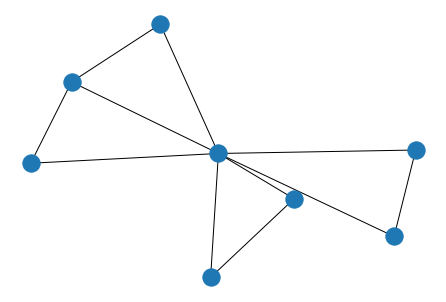

In [98]:
my_graph = graph_list[1]

nx.draw(my_graph)
print(my_graph.edges(data = True))
print('-------------------------')
print(my_graph.nodes(data = True))


### Diversity Measure
Carter 02/19/21 

This comes from pg 5 of the following paper: https://arxiv.org/pdf/0901.1380.pdf



In [70]:

def calculate_diversity(D, probs):
    """
    Calculate Stirling Diversity measure with alpha = beta = 1
    Args:
        param: D - Distance Matrix
        param: probs - list of probabilities in order of Strong Negative, Negative, Weak Negative, Neutral, Weak Positive, Positive, Strong Positive
    """
    S = 0
    for i in range(7):
        for j in range(7):
            S += D[i, j]*probs[i]*probs[j]
    return S

In [48]:
def get_prob_list(block_df, value_list):
    probs_list = []
    
    for j in range(7):
        x = 0
        for i in range(len(block_df)):
            node = block_df['shape'][i]
            
            if node == 'ambivalent':
                node = 'neutral' 
                
            if node == value_list[j]:
                x = x+1
                
        x = x/len(block_df)
        probs_list.append(x)
    
    return probs_list

In [99]:
#Get probabilities of each type of node -- used for diversity calculation
#I generalized this to make it easier if people name their nodes differently


# neg_strong = df[df['shape']=='negative strong'].count()
# neg = df[df['shape']=='negative'].count()
# neg_weak = df[df['shape']=='negative weak'].count()
# neutral = df[(df['shape']=='neutral') & (df['shape']=='ambivalent')].count()
# pos_weak = df[df['shape']=='psoti'].count()
# pos = df[df['shape']=='negative strong'].count()
# pos_strong = df[df['shape']=='negative strong'].count()



In [100]:
positive_list = ['positive strong', 'positive','positive weak']
negative_list = ['negative strong','negative','negative weak']
neutral_list = ['neutral','ambivalent']
node_val_list = negative_list + neutral_list[:-1] + positive_list

In [101]:
# Create distance matrix
D = np.zeros((7,7))  # We have seven node types hence 7 (note that we consider ambivalent as the same as neutral in this calculation)
dist_ = np.arange(7)
for i in range(7):
    D[i,i:] = dist_
    D[i:,i] = dist_
    dist_ = dist_[:-1]

### Calculate Valence 

In [103]:
def valenceCalc(dataframe):
    
#     Calculate average valence using two methods
#     1 - counting ambivalent nodes once
#     2 - counting ambivalent nodes twice
    
    valence_avg = 0
    if len(dataframe['shape']) > 0:  # If there are any concepts!!
        for valence in dataframe['shape']:
            if valence == 'neutral':
                valence_avg += 0
            elif 'positive' in valence:
                if 'weak' in valence:
                    valence_avg += 1
                elif valence == 'positive':
                    valence_avg += 2
                elif 'strong' in valence:
                    valence_avg += 3
            elif 'negative' in valence:
                if 'weak' in valence:
                    valence_avg -= 1
                elif valence == 'negative':
                    valence_avg -= 2
                elif 'strong' in valence:
                    valence_avg -= 3
        option1 = np.round(valence_avg/len(dataframe['shape']), 2)
        option2 = np.round(valence_avg/(len(dataframe['shape'])+len(dataframe[dataframe['shape'] == 'ambivalent'])), 2)
        return option1, option2
    else:
        return 0, 0

## Function to make data frame of GLI for all CAMs

In [108]:
def calc_CAM_GLI(id_list):
    
    dictionary_list = []
    
    for cam_id in id_list:
        
        try:
            df_blocks = pd.read_csv(f'{file_path}/{cam_id}_blocks.csv')
            df_links = pd.read_csv(f'{file_path}/{cam_id}_links.csv')
            
            #Get diversity measure
            try:
                probs = get_prob_list(df_blocks, node_val_list)
                node_diversity = calculate_diversity(D, probs)
            except:
                node_diversity = 999
            
            try:
                node_valence = valenceCalc(df_blocks)
                node_valence_1 = node_valence[0]
                node_valence_2 = node_valence[1]
            except:
                node_valence_1 = 999
                      
            
            # Get nodes
            nodes = df_blocks['id'].to_list()
            
            # Get edges
            edge_start = df_links['starting_block'].to_list()
            edge_end = df_links['ending_block'].to_list()
            edges = tuple(zip(edge_start, edge_end))
            
            # Create Graph
            G = nx.Graph()
            G.add_nodes_from(nodes)
            G.add_edges_from(edges)
            
            # Calculate Density
            density = np.round(nx.density(G), 3)
            node_count = G.number_of_nodes()
            edge_count = G.size()
            
            # Calculate longest path
            try:
                components = nx.connected_components(G)
                largest_component = max(components, key=len)
                subgraph = G.subgraph(largest_component)
                diameter = nx.diameter(subgraph)
            except:
                diameter = 0
            # Calculate transitivity
            triadic_closure = np.round(nx.transitivity(G), 3)
            
            # Calculate max degree
            try:
                degree_centrality = nx.degree_centrality(G)
                max_centrality_ind = np.argmax(list(degree_centrality.values()))
                central_node = list(degree_centrality.keys())[max_centrality_ind]
                central_node_title = df_blocks[df_blocks['id'] == central_node]['title'].values[0]
                central_node_val = np.round(list(degree_centrality.values())[max_centrality_ind], 3)
            except:
                central_node = 0
                central_node_title = ''
                central_node_val = 0
                
            # Eigenvector Centrality
            try:
                eigenvector_centrality = nx.eigenvector_centrality(G)
                max_centrality_ind = np.argmax(list(eigenvector_centrality.values()))
                central_node_val_eig = np.round(list(eigenvector_centrality.values())[max_centrality_ind], 3)
            except:
                central_node_val_eig = 0
                
            # Betweeness Centrality
            try:
                betweenness_centrality = nx.betweenness_centrality(G)
                max_centrality_ind = np.argmax(list(betweenness_centrality.values()))
                central_node_val_bet = np.round(list(betweenness_centrality.values())[max_centrality_ind], 3)
            except:
                central_node_val_bet = 0

            # Make the dictionary
                #add in ratio of node val
                #add number of type of node
            density_dict = {
                'cam_id': cam_id,
                'node_count': node_count,
                'edge_count': edge_count,
                'node_diversity': node_diversity,
                'node_valence_1': node_valence_1,
                'node_valence_2':node_valence_2,
                'density': density,
                'diameter': diameter,
                'triadic_closure': triadic_closure,
                'central_node': central_node,
                'central_node_title': central_node_title,
                'central_node_val': central_node_val,
                'central_node_val_eig': central_node_val_eig,
                'central_node_val_bet': central_node_val_bet
            }

            dictionary_list.append(density_dict)
            
        except:
            print(f'No file found for {cam_id}')
        
    cam_density_df = pd.DataFrame(dictionary_list)
            
    return cam_density_df

In [109]:
cam_GLI_df = calc_CAM_GLI(my_id_list)
display(cam_GLI_df)

No file found for 575ec4be3fc3ac000611df4c__771


,cam_id,node_count,edge_count,node_diversity,node_valence_1,node_valence_2,density,diameter,triadic_closure,central_node,central_node_title,central_node_val,central_node_val_eig,central_node_val_bet
0,5f32a496a026e809d7d55cbd_817,7,10,1.224490,1.29,1.12,0.476,2,0.480,13562,Carbon Tax,1.000,0.595,0.667
1,5f67f8d55e7718150fd23bc7_802,8,11,1.781250,0.88,0.88,0.393,2,0.400,13480,Carbon Tax,1.000,0.623,0.786
2,5e45dd10f354ca0c7f4225c7_903,10,9,1.840000,0.00,0.00,0.200,5,0.000,14076,economic growth,0.444,0.566,0.722
3,5f4ae6a7ad7baa6aecef4234_990,14,13,2.275510,-0.93,-0.93,0.143,7,0.000,14686,Unequal effect on classes and regions,0.231,0.471,0.667
4,5a4e8f4930adf7000106fd5e_928,12,12,1.944444,0.00,0.00,0.182,6,0.000,14279,Financial Burden,0.364,0.470,0.636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,5f57fef7e7b06a35296f215d_822,12,17,1.777778,0.00,0.00,0.258,5,0.214,13629,Economy,0.455,0.467,0.544
154,5b0f33dd1e55760001b9a9ce_812,11,22,1.652893,0.91,0.91,0.400,3,0.495,13542,Carbon Tax,0.800,0.470,0.369
155,5ca6c9f3a752220001ca1be3_838,9,6,1.876543,0.11,0.11,0.167,3,0.333,13693,Carbon Tax,0.500,0.628,0.286
156,5f7dd740074da20008c51bf5_818,7,8,2.612245,-0.14,-0.14,0.381,4,0.400,13566,Carbon Tax,0.667,0.552,0.567


In [110]:
#get a df of the number of cams per node count
node_count_df = pd.DataFrame(cam_GLI_df.groupby('node_count',as_index=False).count()[['node_count','edge_count']]).rename(columns={'edge_count':'cam_count'})
node_count_df.head(5)

,node_count,cam_count
0,0,24
1,1,4
2,2,2
3,3,5
4,4,4


#### Look at distribution of node count

Text(0.5, 1.0, 'Distribution of Node Count')

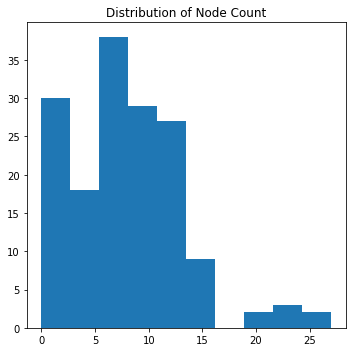

In [111]:
fig, axs = plt.subplots(figsize=(5,5),sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs.hist(cam_GLI_df['node_count'])
axs.set_title('Distribution of Node Count')


## Simulations

#### Compare GLI from CAM with what would be expected from chance <br> assumption: graph probability distribution is uniform, conditioned on size and density
 (all graphs of given size and density are equally probable)

### Anderson et al. Approach

In [115]:
col_list = list(cam_GLI_df.columns)
GLI_list = col_list[8:]
GLI_list

['triadic_closure',
 'central_node',
 'central_node_title',
 'central_node_val',
 'central_node_val_eig',
 'central_node_val_bet']

In [113]:
print(len(cam_GLI_df))

158


In [116]:
GLI_name = GLI_list[3]

P_H = 0
P_L = 0
P_E = 0
N = 0 

N_max = 100 #number of iterations

alpha = .05 # desired level of significance

condition_list = []
sig_cam_list = []
nonsig_cam_list = []

for i in range(len(cam_GLI_df)):
    
    Obs_GLI = cam_GLI_df[GLI_name][i] #observed GLI from row i

    n = cam_GLI_df['node_count'][i] # number of nodes for cam i
    m = cam_GLI_df['edge_count'][i]  # number of edges for cam i

    while N < N_max:

        # STEP 2: Make the random graph
        G_uni = nx.gnm_random_graph(n, m)


        #Get the necessary GLI measures
        # Calculate Density
        density = np.round(nx.density(G_uni), 3)

        # Calculate longest path
        try:
            components = nx.connected_components(G_uni)
            largest_component = max(components, key=len)
            subgraph = G_uni.subgraph(largest_component)
            diameter = nx.diameter(subgraph)
        except:
            diameter = 0
        # Calculate transitivity
        triadic_closure = np.round(nx.transitivity(G_uni), 3)

        # Calculate max degree
        try:
            degree_centrality = nx.degree_centrality(G_uni)
            max_centrality_ind = np.argmax(list(degree_centrality.values()))
            central_node_val = np.round(list(degree_centrality.values())[max_centrality_ind], 3)
        except:
            central_node_val = 0

        # Eigenvector Centrality
        try:
            eigenvector_centrality = nx.eigenvector_centrality(G_uni)
            max_centrality_ind = np.argmax(list(eigenvector_centrality.values()))
            central_node_val_eig = np.round(list(eigenvector_centrality.values())[max_centrality_ind], 3)
        except:
            central_node_val_eig = 0

        # Betweeness Centrality
        try:
            betweenness_centrality = nx.betweenness_centrality(G_uni)
            max_centrality_ind = np.argmax(list(betweenness_centrality.values()))
            central_node_val_bet = np.round(list(betweenness_centrality.values())[max_centrality_ind], 3)
        except:
            central_node_val_bet = 0

        # Make the dictionary
        G_uni_GLI_dict = {
            'central_node_val': central_node_val,
            'central_node_val_eig': central_node_val_eig,
            'central_node_val_bet': central_node_val_bet
        }

        #STEP 3 - #Maybe issue with have a two conditions with the 'equal to' option
        
        if G_uni_GLI_dict[GLI_name] >= Obs_GLI:
            P_H = P_H + 1

        elif G_uni_GLI_dict[GLI_name] <= Obs_GLI:
            P_L = P_L +1

        #increment N for each iteration till max is reached
        N = N + 1

    #Step 5 - This tests whether the observed GLI is consistently either higher or lower than the GLI predicted
    # by a random graph. 
    condition_1 = (P_H/N_max) < (alpha/2)
    condition_2 = (P_L/N_max) < (alpha/2)
    
    condition_list.append((P_H/N_max,P_L/N_max))

    if condition_1 | condition_2:
        
        sig_cam_list.append(cam_GLI_df['cam_id'][i])
    
    else:
        nonsig_cam_list.append(cam_GLI_df['cam_id'][i])

In [117]:
 len(nonsig_cam_list)

0

### Carter approach:
disprove that size impacts 
build random graph with different node size
create likelihood function

G_uni = nx.gnm_random_graph(n, m) density fixed 
G = nx.gnp_random_graph(n,p) density varies


## Add Survey Info to CAM data

In [118]:
file_path_survey = '/Users/agetecza/CAM_Data/AT_CAM/Data/CAM_Survey_Merged.csv'
survey_df = pd.read_csv(file_path_survey)
survey_df.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,WilsonPat_5,WilsonPat_6,WilsonPat_7,WilsonPat_8,WilsonPat_9,WilsonPat_10,WilsonPat_11,WilsonPat_12,CheckNum,mTurkCode2
0,2021-01-11 11:46,2021-01-11 11:46,0,50.69.196.183,100,8,1,2021-01-11 11:46,R_2ZQySv7eilk1BhL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-11 11:48,2021-01-11 11:59,0,50.69.196.183,100,660,1,2021-01-11 11:59,R_8erRxEBvfzDsLGp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-11 11:51,2021-01-11 12:01,0,69.158.246.27,100,635,1,2021-01-11 12:01,R_xgzbLgWncp56ACJ,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-11 12:01,2021-01-11 12:13,0,24.212.224.202,100,739,1,2021-01-11 12:13,R_3rOr7B1NkrQgen5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-11 12:04,2021-01-11 12:18,0,24.77.79.89,100,820,1,2021-01-11 12:18,R_1KdKzGSFXHqdKef,NaN,...,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,8165033.0


In [119]:
#drop NAs
survey_df_dropna = survey_df.dropna(subset=['Prolific1','Gender'])

In [120]:
#Get the cam dataframe ready to merge with the survey data
cam_GLI_full = cam_GLI_df.copy()
Prolific1_list=cam_GLI_full['cam_id'].str.split('_').str[0]
cam_GLI_full.insert(loc=0, column='Prolific1', value=Prolific1_list)
cam_GLI_full = cam_GLI_full.drop(cam_GLI_full.columns[1], axis=1)

In [121]:
print(f'The length of cam_df: {len(cam_GLI_full)}')
print(f'The length of survey_df: {len(survey_df_dropna)}')

The length of cam_df: 158
The length of survey_df: 141


In [122]:
survey_cam_merge = pd.merge(cam_GLI_full, survey_df_dropna, how = 'inner', on = 'Prolific1')

In [123]:
print(f'The length of merged data: {len(survey_cam_merge)}')

The length of merged data: 120


## Cleaning the combined dataframe

#### Drop all rows with node_count less than 3 or link_count less than 2

In [124]:
filter_cam = (survey_cam_merge['node_count']>3) & (survey_cam_merge['edge_count']>2)
survey_merge_large_cam = survey_cam_merge[filter_cam]

In [125]:
print(f'{len(survey_merge_large_cam)} rows have more than 3 nodes and more than 2 edges')

113 rows have more than 3 nodes and more than 2 edges


#### Drop Survey checks???

### Select Variables for Analysis

In [153]:
#Get list of all column/variables names
survey_column_list = list(survey_merge_large_cam.columns)
survey_column_list

['Prolific1',
 'node_count',
 'edge_count',
 'node_diversity',
 'node_valence_1',
 'node_valence_2',
 'density',
 'diameter',
 'triadic_closure',
 'central_node',
 'central_node_title',
 'central_node_val',
 'central_node_val_eig',
 'central_node_val_bet',
 'StartDate',
 'EndDate',
 'Status',
 'IPAddress',
 'Progress',
 'Duration (in seconds)',
 'Finished',
 'RecordedDate',
 'ResponseId',
 'RecipientLastName',
 'RecipientFirstName',
 'RecipientEmail',
 'ExternalReference',
 'LocationLatitude',
 'LocationLongitude',
 'DistributionChannel',
 'UserLanguage',
 'Screen1',
 'Consent2',
 'Prolific2',
 'Time1_First Click',
 'Time1_Last Click',
 'Time1_Page Submit',
 'Time1_Click Count',
 'CarbFam',
 'CarbSFam',
 'CarbAg',
 'CarbDis',
 'CarbHear',
 'CarbTextD',
 'Interest_1',
 'CarbDecide',
 'TutorialConfirmation',
 'CAMCheck1',
 'CAMCheck2',
 'CAMCheck3',
 'CAMCheck4',
 'Complete',
 'TreatmentCheck',
 'Represent_1',
 'Stop',
 'mTurkCode',
 'Prolific2 - Parent Topics',
 'Prolific2 - Topics',
 '

In [134]:
#Check the index of a specific variable
survey_column_list.index('central_node_val_bet') 

13

In [154]:
#Get all quality checks
quality_check_list = ['Duration (in seconds)','TutorialConfirmation','TreatmentCheck','CAMCheck1']

In [135]:
#Get all the controls
control_list_1 = ['Age','Education','Income','English','Gender','CarbFam','CarbSFam']
control_list_Cog = survey_column_list[108:126]
control_list_Aff = survey_column_list[126:152]
control_list_KN = survey_column_list[173:180]

control_list = control_list_1 + control_list_Aff + control_list_Cog + control_list_KN

In [155]:
#Get all variable
end_network_index = survey_column_list.index('central_node_val_bet')
network_list = survey_column_list[:end_network_index]
dependent_list = ['CarbAg','Interest_1','CarbDecide']
full_variable_list = network_list + dependent_list + control_list +  quality_check_list

In [156]:
#subset df 
survey_df_analysis = survey_merge_large_cam.loc[:,full_variable_list]

In [158]:
len(survey_df_analysis)

113

In [157]:
survey_df_analysis.head()

,Prolific1,node_count,edge_count,node_diversity,node_valence_1,node_valence_2,density,diameter,triadic_closure,central_node,...,KNDate,KNPrice,KNTimes,KNBC,KNPerc,KNRef,Duration (in seconds),TutorialConfirmation,TreatmentCheck,CAMCheck1
0,5f32a496a026e809d7d55cbd,7,10,1.224490,1.29,1.12,0.476,2,0.48,13562,...,1.0,1.0,3.0,3.0,2.0,1.0,1025,1.0,3.0,1.0
1,5f67f8d55e7718150fd23bc7,8,11,1.781250,0.88,0.88,0.393,2,0.40,13480,...,2.0,2.0,2.0,2.0,2.0,2.0,1062,1.0,3.0,1.0
2,5e45dd10f354ca0c7f4225c7,10,9,1.840000,0.00,0.00,0.200,5,0.00,14076,...,2.0,2.0,2.0,2.0,2.0,1.0,3291,1.0,3.0,1.0
3,5f4ae6a7ad7baa6aecef4234,14,13,2.275510,-0.93,-0.93,0.143,7,0.00,14686,...,3.0,3.0,1.0,3.0,2.0,3.0,3114,1.0,3.0,1.0
4,5a4e8f4930adf7000106fd5e,12,12,1.944444,0.00,0.00,0.182,6,0.00,14279,...,2.0,2.0,2.0,3.0,2.0,2.0,1383,1.0,3.0,2.0


In [159]:
#### Export clean csv (note, quality checks have not been filtered)
survey_df_analysis.to_csv("/Users/agetecza/CAM_Data/AT_CAM/Data/Combined_df.csv", index = False)

### Descriptives

In [145]:
variable_list = list(survey_df_analysis.columns)

In [146]:
summary_df = pd.DataFrame(survey_df_analysis[variable_list].describe()).transpose()
summary_df

,count,mean,std,min,25%,50%,75%,max
node_count,113.0,9.778761,4.451594,4.0,7.000000,9.0000,12.000000,27.00000
edge_count,113.0,13.469027,8.585776,3.0,8.000000,12.0000,16.000000,63.00000
node_diversity,113.0,1.783540,0.495283,0.0,1.487603,1.8432,2.111111,2.68144
node_valence_1,113.0,0.198142,0.788388,-3.0,-0.170000,0.1700,0.700000,2.00000
node_valence_2,113.0,0.187788,0.755325,-3.0,-0.170000,0.1700,0.670000,2.00000
...,...,...,...,...,...,...,...,...
KNPrice,113.0,2.150442,0.585864,1.0,2.000000,2.0000,3.000000,3.00000
KNTimes,113.0,1.831858,0.461029,1.0,2.000000,2.0000,2.000000,3.00000
KNBC,113.0,2.292035,0.561907,1.0,2.000000,2.0000,3.000000,3.00000
KNPerc,113.0,1.964602,0.325390,1.0,2.000000,2.0000,2.000000,3.00000


## Assumption

### Correlation & Dimension Reduction

In [147]:
#Clean up column order
#column_order = list(np.arange(0,21))+list(np.arange(47,50))+list(np.arange(65,68))+list(np.arange(24,47))+list(np.arange(50,65))+list(np.arange(21,24))+list(np.arange(68,72))
#survey_df_arrange = survey_df_analysis.iloc[:,column_order]
#survey_df_arrange.head()

In [148]:
correlation_matrix = survey_df_analysis.corr()

In [149]:
correlation_matrix.iloc[7,5]

0.6966242068223083

In [150]:
corr_df = pd.DataFrame(columns = ['row','column','corr'])
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix)):
        if (correlation_matrix.iloc[i,j]>.6) & (correlation_matrix.iloc[i,j]!=1):
            newrow = {'row':correlation_matrix.columns[i],'column':correlation_matrix.columns[j],'corr':correlation_matrix.iloc[i,j]}
            corr_df = corr_df.append(newrow, ignore_index=True)
            

In [151]:
corr_df

,row,column,corr
0,node_count,edge_count,0.842091
1,edge_count,node_count,0.842091
2,node_valence_1,node_valence_2,0.997517
3,node_valence_2,node_valence_1,0.997517
4,density,triadic_closure,0.696624
5,density,central_node_val,0.647375
6,triadic_closure,density,0.696624
7,central_node_val,density,0.647375
8,Aff5,Aff24,0.653327
9,Aff6,Aff18,0.740150


In [ ]:
import seaborn as sns
plt.subplots(figsize=(25,15))
sns.heatmap(correlation_matrix)

In [ ]:
list(survey_df_analysis.columns).index('Aff1R')

In [ ]:
#Isolate variables for individual heat mapping
Cog_index = list(np.arange(list(survey_df_analysis.columns).index('Cog1'),list(survey_df_analysis.columns).index('Cog18')+1))
Aff_index = list(np.arange(list(survey_df_analysis.columns).index('Aff1R'),list(survey_df_analysis.columns).index('Aff26')+1))
Cog_df = survey_df_analysis.iloc[:,Cog_index]
Aff_df = survey_df_analysis.iloc[:,Aff_index]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

sns.heatmap(Cog_df.corr(), ax=ax1)
sns.heatmap(Aff_df.corr(), ax=ax2)

plt.show()

#### Dimension Reduction

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
x_pca = pca.fit_transform(Aff_df)
x_pca = pd.DataFrame(x_pca)
x_pca.head(10)

In [ ]:
explained_variance = pca.explained_variance_ratio_
explained_variance

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(range(len(x_pca.columns)), explained_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

#### Check linear regression plots

In [ ]:
variable_index = variable_list.index('KNPrice') #Just enter the variable name you want an output for 

variable_name = variable_list[variable_index]

fig, axs = plt.subplots(figsize=(5,5),sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs.hist(survey_cam_merge[variable_name])
axs.set_title(f'{variable_name}')

Create output of assumption test
peirce test of normality for indep variable
ind:
dv:

In [ ]:
#Are these switched?
survey_dependent = survey_df_analysis[dependent_list]
survey_network = survey_df_analysis[network_list]
survey_c1 = survey_df_analysis[control_list_1]


In [ ]:
print(list(survey_network.columns))
survey_cent = survey_network.iloc[:,[6,13]]

In [ ]:
#For all the below graphs:
y = survey_dependent
X = survey_cent

In [ ]:
import scipy.stats as st
fig, axes = plt.subplots(nrows=len(y.columns), ncols=len(X.columns), figsize=(15, 10))
                                   
for i in range(len(y.columns)):
    for j in range(len(X.columns)):
        axes[i, j].scatter(X.iloc[:,j],y.iloc[:,i])
        axes[i,j].set_xlabel(f'{X.columns[j]}',fontsize=10)
        
        
        slope, inter, r, p, std_err = st.linregress(X.iloc[:,j],y.iloc[:,i])
        plot_fit = slope * (X.iloc[:,j]) + inter
        axes[i,j].plot((X.iloc[:,j]),plot_fit,linestyle='solid',color="red",lw=.3)
        
        if j ==0:
            axes[i,j].set_ylabel(f'{y.columns[i]}',fontsize=10)
            
fig.tight_layout()


#### Data transformations?

boxcox shorthand:
lambda = -1. is a reciprocal transform.
lambda = -0.5 is a reciprocal square root transform.
lambda = 0.0 is a log transform.
lambda = 0.5 is a square root transform.
lambda = 1.0 is no transform.

In [ ]:
from scipy.stats import boxcox
data = boxcox(y.iloc[:,1], 0)
data

#### Assumption Testing for OLS

In [ ]:
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

In [ ]:
unique_values = survey_dependent.iloc[:,0].unique()
unique_values

In [ ]:
X = survey_cent
X = sm.add_constant(X)
y = survey_dependent.iloc[:,0]

# generate OLS model
model = sm.OLS(y, X)
model_fit = model.fit()
# create dataframe from X, y for easier plot handling
dataframe = pd.concat([X, y], axis=1)

In [ ]:
X.head()

In [ ]:
print(model_fit.summary())

In [ ]:
# model values
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

In [ ]:
#further from line = errors not being normally distributed
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');




In [ ]:
#The more horizontal the red line is, the more likely the data is homoscedastic
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
          scatter=False,
          ci=False,
          lowess=True,
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');



In [ ]:
#Cook’s Distance, we only need to find leverage points that have a distance greater than 0.5 (above dotted red line). 

plot_lm_4 = plt.figure();
plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
sns.regplot(model_leverage, model_norm_residuals,
          scatter=False,
          ci=False,
          lowess=True,
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals');

# shenanigans for cook's distance....not sure this is right 
def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

# annotations


p = len(model_fit.params) # number of model parameters
graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
    np.linspace(0.001, max(model_leverage), 50),
    'Cook\'s distance') # 0.5 line

#graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
    #np.linspace(0.001, max(model_leverage), 50)) # 1 line

plot_lm_4.legend(loc='upper right');

## GLM

In [ ]:
from patsy import dmatrices
import statsmodels.api as sm

formula = """dep ~ ind1 + C(ind2_catagorical) )"""

response, predictors = dmatrices(formula, data, return_type='dataframe')
po_results = sm.GLM(response, predictors, family=sm.families.Poisson()).fit()
print(po_results.summary())

In [ ]:
# Poisson regression code
import statsmodels.api as sm

exog, endog = sm.add_constant(x), y

mod = sm.GLM(endog, exog, family=sm.families.Poisson(link=sm.families.links.log))

res = mod.fit()

# Coor Analysis

create a clustering coef.
net measure predicts feelings about carbon tax
show optimal binning variable